# Kaylee Li

## Research Question/Interests

Spring in Vancouver is a great time for picnics, but instead of randomly choosing a park, why not use tree data to find the best spots? Trees offer shade, beauty, and a peaceful atmosphere, making them key to a good picnic experience. How can we use tree data to find the best picnic locations in Vancouver?

#### Main Research Question:
How can the Vancouver tree dataset help identify the best locations for spring picnics in Vancouver, tailored to different preferences? (Research focus: Neighbourhood-level analysis)

#### Sub Questions:
1. Shade Seekers: Which neighbourhoods have the highest density of large trees (e.g., height over 40 feet) that provide ample shade for comfortable picnic spots? Large trees are essential for creating shaded areas, which can significantly enhance the picnic experience on sunny days.

2. Aesthetic Enthusiasts: Which neighbourhoods have the highest diversity of tree families, offering visually varied and unique picnic environments? A mix of tree species can create a more aesthetically pleasing and engaging atmosphere for picnickers.

3. Allergy-Conscious Individuals: Which neighbourhoods have trees that produce high amounts of pollen, potentially affecting picnic experiences for people with allergies? Identifying high-pollen areas can help allergy sufferers avoid discomfort or plan allergy-friendly events.

#### Align with FINER criteria:

- Feasible: The Vancouver tree dataset provides the necessary information to identify ideal picnic spots, making the analysis practical and achievable. Additionally, I’ve been using API calls to gather related information about the trees based on their scientific names, which further enriches the dataset.
- Interesting: The research addresses a common desire for optimal picnic locations, especially with spring approaching, specifically for people in Vancouver. It also takes allergy concerns into account, making the project both engaging and valuable for the target audience.
- Novel: Using tree data to identify picnic spots is a unique approach, particularly with a focus on tree size, diversity, and pollen levels. I haven't found a map specific to Vancouver for picnics, which makes this research stand out and adds a fresh perspective.
- Ethical: The project relies on publicly available data, ensuring privacy is respected, while also considering public health by identifying allergy-friendly spaces for outdoor activities.
- Relevant: The research is highly relevant to urban planning, environmental science, and public health—fields that are becoming increasingly important in today’s cities.

#### Task Analysis:
- Retrieve Value: Retrieve the number of large trees (height over 40 feet) in each neighbourhood.
- Filter: Filter neighbourhoods with the highest density of large trees for shaded picnic spots.
- Compute Derived Value: Calculate the tree families diversity in each neighbourhood.
- Sort: Rank neighbourhoods by tree density or diversity.

In [1]:
import sys
sys.path.append("../../code")

import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer

from pygbif import species
import requests
from bs4 import BeautifulSoup
import json
from IPython.display import Image


import altair as alt
import pre_commit as pc
import pandas as pd

from toolz.curried import pipe
import os

In [2]:
import importlib
importlib.reload(preprocess_query_family)
importlib.reload(preprocess_query_pollen)
importlib.reload(preprocess_change_col_type)
importlib.reload(altair_data_transformer)

<module 'altair_data_transformer' from 'C:\\Users\\ljung\\Desktop\\git\\dsci320\\project-team_kbn\\analysis\\Picnic\\../../code\\altair_data_transformer.py'>

In [3]:
data_dir = 'altairdata'

altair_data_transformer.setup_altair_for_large_data(data_dir)

In [4]:
# raw dataframe
raw_df = pd.read_csv("../../data/raw/public-trees.csv", delimiter=";")

### Data Processing 

#### (i) Finding Respective Family Name (creating `FAMILY_NAME` column)

- One of my tasks was querying the respective family of the plants due to the large number of species.
- Family is a higher taxonomic rank, positioned above genus and species in the biological classification hierarchy.
- I've queried the respective family based on the genus name from Global Biodiversity Information Facility (GBIF) database (https://www.gbif.org/) using their GBIF API.
- The respective family is then stored into `FAMILY_NAME` column - there are no NA values.

In [5]:
# this find and creates a dictionary:key mapping for all the unique genus based on GBIF database
# This step takes a while, so the result is saved to a file for future use.
# Uncomment the following lines to regenerate the dictionary and save it.

# genus_to_family_dict = preprocess_query_family.get_genus_to_family_mapping(raw_df)

# Save the dictionary to a json file for efficiency
# with open("../../data/processed/genus_to_family_dict.json", "w") as file:
#     json.dump(genus_to_family_dict, file, indent=4)

In [6]:
# load the dictionary:key mapping back into a dictionary
with open("../../data/processed/genus_to_family_dict.json", "r") as file:
    genus_to_family_dict = json.load(file)

In [7]:
# This maps the genus to its respective family using the genus-to-family dictionary
# there are no NA genus, and also no NA family
df_with_family = preprocess_query_family.map_family_to_dataframe(raw_df, genus_to_family_dict)

In [8]:
# this binds the "FAMILY_NAME" column to `../../data/processed/public_trees_cleaned.csv` based on TREE_ID (bc tree ID is unique)
# done like this because im not the only one doing data processing and let other teammate also use this column as well

preprocess_query_family.add_family_name_to_cleaned("../../data/processed/public_trees_cleaned.csv", df_with_family)

FAMILY_NAME already exists. Overwriting the column.
FAMILY_NAME added/overwritten in CSV.


#### (ii) Finding if Tree has Pollen or Not (creating `HAS_POLLEN` column)

- One of my own question is wonder if there neighbourhood with trees that produce high amount of pollen, and to do that, I need to know which tree species has pollen to begin with.
- Pollen production was determined by checking if the tree's scientific name (genus + species) exists in the Palynological Database (PalDat) (https://www.paldat.org/), a comprehensive resource for pollen data.
- The logic was implemented to return True if the tree's scientific name was found in the PalDat database (indicating pollen production) and False otherwise.
- Web scraping was used to extract and match pollen-related data from PalDat with the tree species in my dataset.
- The respective pollen status is then stored into `HAS_POLLEN` column - there are no NA values.

In [9]:
# this find and create a list of trees that produce pollen according to PalDat database 
# This step takes a while, so the result is saved to a file for future use.
# Uncomment the following lines to regenerate the list and save it.

# tree_that_has_pollen_list = preprocess_query_pollen.search_species_list(raw_df)

# Save the list to a text file for efficiency
# with open("data/processed/tree_that_has_pollen_list.txt", "w") as file:
#     for item in tree_that_has_pollen_list:
#         file.write(f"{item}\n")

In [10]:
# read the tree_that_has_pollen_list.txt back into a list 

with open("../../data/processed/tree_that_has_pollen_list.txt", "r") as file:
    tree_that_has_pollen_list = [line.strip() for line in file]

In [11]:
# Map the `HAS_POLLEN` column to the dataframe using the list of pollen-producing trees

df_with_has_pollen = preprocess_query_pollen.map_has_pollen_to_dataframe(raw_df, tree_that_has_pollen_list)

In [12]:
# this binds the "HAS_POLLEN" column to `../../data/processed/public_trees_cleaned.csv` based on TREE_ID (bc tree ID is unique)
# done like this because im not the only one doing data processing and let other teammate also use this column as well

preprocess_query_pollen.add_has_pollen_to_cleaned("../../data/processed/public_trees_cleaned.csv", df_with_has_pollen)

HAS_POLLEN already exists. Replacing the column.
HAS_POLLEN replaced in the CSV.


#### (iii) Other preprocess + Cleaning done by Teammate


- *Handling Missing Values*:
    - `CULTIVAR_NAME` is filled with values from `SPECIES_NAME` where missing.
    - `NEIGHBOURHOOD_NAME` is filled with the string `'NA'` for missing values.
    - `DATE_PLANTED` is filled with an empty string (`''`) for missing values.

- *Splitting Latitude and Longitude*:
    - The `geo_point_2d` column, which contains both latitude and longitude, is split into two new columns: `LATITUDE` and `LONGITUDE`.
    - These columns are then converted to floating-point values.

- *Replacing Height Range IDs*:
    - The values `0` and `10` in the `HEIGHT_RANGE_ID` column are replaced with `9` because they represent the same height range (`'>90'`).

- *Creating Nomenclature Column*:
    - A new column `NOMENCLATURE` is created by combining `GENUS_NAME` and `SPECIES_NAME` into a single string.

- *Creating Full Address Column*:
    - A new column `ON_ADDRESS` is created by combining `ON_STREET_BLOCK`, `ON_STREET`, `NEIGHBOURHOOD_NAME`, and `STREET_SIDE_NAME` into a formatted address.

## EDA Specific to My Research Questions

In [13]:
processed_df = pd.read_csv("../../data/processed/public_trees_cleaned.csv")

# covert column to respective column type
processed_df = preprocess_change_col_type.convert_column_types(processed_df)

In [14]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181501 entries, 0 to 181500
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   TREE_ID             181501 non-null  int64         
 1   CIVIC_NUMBER        181450 non-null  category      
 2   STD_STREET          181450 non-null  category      
 3   GENUS_NAME          181450 non-null  category      
 4   SPECIES_NAME        181450 non-null  category      
 5   CULTIVAR_NAME       181450 non-null  category      
 6   COMMON_NAME         181450 non-null  category      
 7   ON_STREET_BLOCK     181450 non-null  category      
 8   ON_STREET           181450 non-null  category      
 9   NEIGHBOURHOOD_NAME  177522 non-null  object        
 10  STREET_SIDE_NAME    181450 non-null  object        
 11  HEIGHT_RANGE_ID     181450 non-null  float64       
 12  HEIGHT_RANGE        181450 non-null  category      
 13  DIAMETER            181450 no

#### (i) Density of Large Trees by Neighbourhood

Large trees provide shade, which is essential for comfortable picnic spots. To identify neighbourhoods with the highest density of large trees, I've plot the distribution of trees with a diameter greater than 40 feet (classified as "large trees").

In [15]:
# Filter for tall trees, those taller than 40 feet

large_tree_ranges = ['40-50', '50-60', '60-70', '70-80', '80-90', '>90']
filtered_large_trees = processed_df[processed_df['HEIGHT_RANGE'].isin(large_tree_ranges)]

# Create the chart for large tree density by neighbourhood
large_tree_distribution = alt.Chart(filtered_large_trees).mark_bar().encode(
    x=alt.X('NEIGHBOURHOOD_NAME:N', sort='-y', title="Neighbourhood Name", axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('count():Q', title="Number of Large Trees"),
    color=alt.Color('HEIGHT_RANGE:N', title="Height Range (in Feet)", legend=alt.Legend(title="Height Range")),
    tooltip=['NEIGHBOURHOOD_NAME:N', 'count():Q', 'HEIGHT_RANGE:N']
).properties(
    width=900, 
    height=300, 
    title= "Distribution of Large Trees (Height > 40 Feet) by Neighbourhood",
).configure_legend(
    titleFontSize=12,
    labelFontSize=10
).configure_title(
    anchor='middle',  
    fontSize=13
)

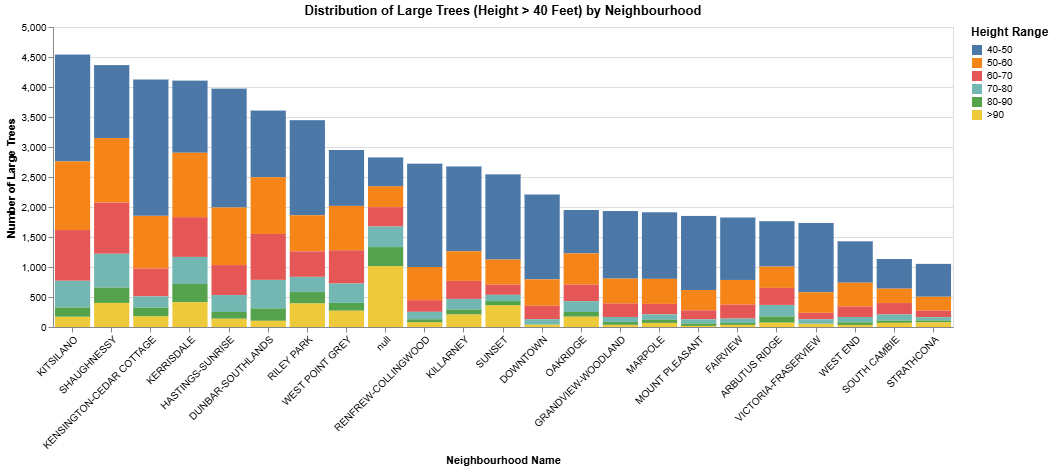

In [16]:
large_tree_distribution

In [17]:
# save as figure for report
# large_tree_distribution.save("../../images/kli_eda1/large_tree_distribution.png")

#### Insight from the figure:
- Kitsilano has the highest number of large trees, making it potentially the most optimal area for a picnic.
- The significant presence of large trees labeled as "Null" suggests that many trees are not assigned to specific neighborhoods, possibly due to data collection issues or missing information. Investigating and properly labeling these "Null" entries could improve understanding of tree distribution and support urban planning and environmental management.
- It is surprising that Strathcona has the lowest number of large trees, despite containing parks like MacLean Park and Strathcona Park. This could indicate a higher proportion of open ground or local factors affecting tree growth in the area.

#### (ii) Diversity of Tree Families by Neighbourhood

A diverse range of tree species can enhance the aesthetic appeal of picnic spots. To measure diversity, I've calculated the number of unique tree families in each neighbourhood and colored the bars based on whether these families produce pollen or not. This approach meets the requirement of having bi-variate figures.

In [18]:
unique_trees_per_neighbourhood_colored_by_pollen = alt.Chart(processed_df).mark_bar().encode(
    alt.X('NEIGHBOURHOOD_NAME:N',  title='Neighbourhood', axis=alt.Axis(labelAngle=-45), sort='-y'), 
    alt.Y('distinct(FAMILY_NAME):Q', title='Number of Unique Tree Families'), 
    alt.Color('HAS_POLLEN:N', title='Has Pollen', scale=alt.Scale(scheme='category10')),
    alt.Tooltip(['NEIGHBOURHOOD_NAME:N', 'distinct(FAMILY_NAME):Q'])  
).properties(
    title='Number of Unique Tree Families per Neighbourhood Colored by Pollen', 
    width=900, 
    height=300, 
).configure_title(
    anchor='middle',  
    fontSize=13
)

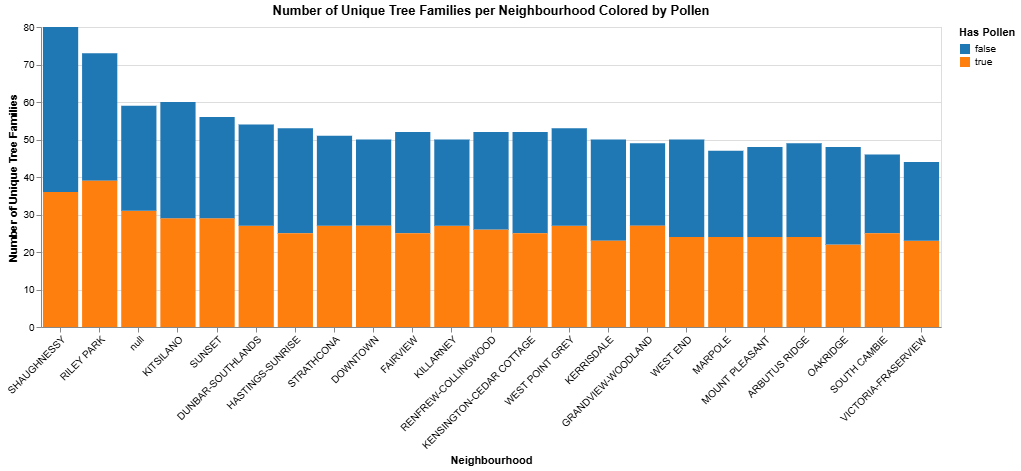

In [19]:
unique_trees_per_neighbourhood_colored_by_pollen

In [20]:
# save as figure for report
unique_trees_per_neighbourhood_colored_by_pollen.save("../../images/kli_eda1/unique_trees_per_neighbourhood_colored_by_pollen.png")

#### Insight from the figure:
- The neighbourhood with the highest tree family diversity is Shaughnessy. This is not very surprising, as the area is home to the VanDusen Botanical Garden, which likely contributes significantly to the variety of tree species present in the region.
- A significant number of trees with high diversity are not assigned to any specific neighbourhood. It might be interesting to explore where these unclassified trees are actually located and perhaps assign them to a neighbourhood.
- Most other neighbourhoods have a relatively similar number of unique tree families, with no drastic differences in diversity.
- We can also observed that there are roughly equal amount of pollen and non-pollen tree family in each neighbhourhood.

#### (iii)  Pollen Distribution by Neighbourhood

Trees that produce high amounts of pollen can negatively impact picnic experiences, especially for individuals with allergies. I've analyzed the distribution of trees that produce pollen and without across neighbourhoods.

In [21]:
aggregated_df = processed_df.groupby(['NEIGHBOURHOOD_NAME', 'HAS_POLLEN'], observed=True).size().reset_index(name='count')

aggregated_df = aggregated_df.sort_values(by='count', ascending=False)

tree_count_with_without_pollen_per_neighbourhood = alt.Chart(aggregated_df).mark_bar().encode(
    x=alt.X('NEIGHBOURHOOD_NAME:N', title="Neighbourhood", axis=alt.Axis(labelAngle=-45), sort='-y'),
    y=alt.Y('count:Q', title="Count of Trees"),
    color=alt.Color('HAS_POLLEN:N', 
                    title="Has Pollen", 
                    scale=alt.Scale(domain=[True, False], range=['#00B4D8', '#E69F00'])),
    tooltip=['NEIGHBOURHOOD_NAME:N', 'HAS_POLLEN:N', 'count:Q']
).properties(
    width=900, 
    height=300, 
    title="Count of Trees with or without Pollen in Each Neighbourhood"
)

# --------------------------------------------------------
no_pollen_df = processed_df[processed_df['HAS_POLLEN'] == False]

map_without_pollen = alt.Chart(no_pollen_df).mark_circle(opacity=0.3, size=2).encode(
    alt.X('LONGITUDE:Q', scale=alt.Scale(zero=False), title="Longitude"),
    alt.Y('LATITUDE:Q', scale=alt.Scale(zero=False), title="Latitude"),
    alt.ColorValue('#00B4D8'),
    alt.Tooltip(['LATITUDE', 'LONGITUDE', 'HAS_POLLEN'])
).properties(
    title="Tree Without Pollen Across Neighbourhoods in Vancouver", 
    width=450,
    height=450
)

with_pollen_df = processed_df[processed_df['HAS_POLLEN'] == True]

map_with_pollen = alt.Chart(with_pollen_df).mark_circle(opacity=0.3, size=2).encode(
    alt.X('LONGITUDE:Q', scale=alt.Scale(zero=False), title="Longitude"),
    alt.Y('LATITUDE:Q', scale=alt.Scale(zero=False), title="Latitude"),
    alt.ColorValue('#E69F00'),
    alt.Tooltip(['LATITUDE', 'LONGITUDE', 'HAS_POLLEN'])
).properties(
    title="Tree With Pollen Across Neighbourhoods in Vancouver",
    width=450,
    height=450
)

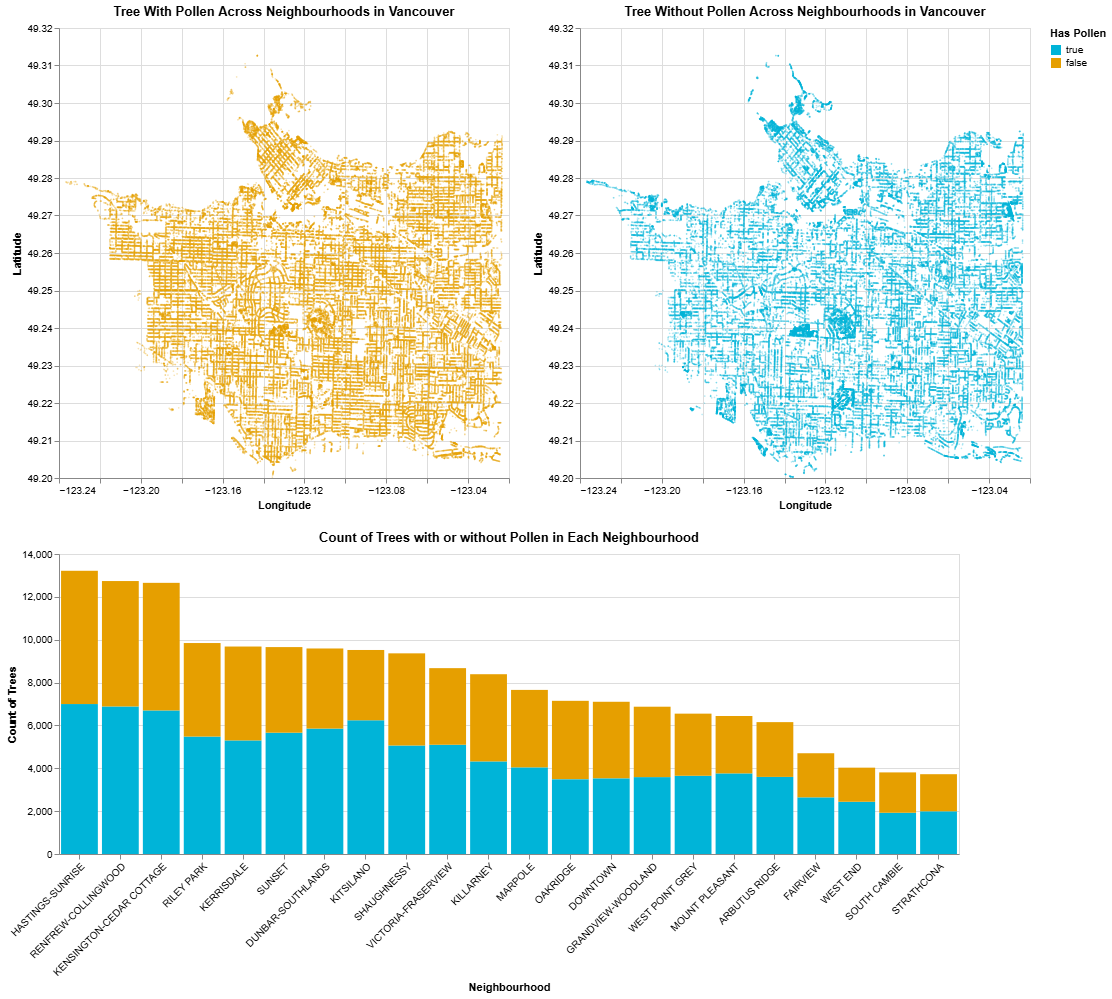

In [22]:
combined_pollen_figure = (map_with_pollen | map_without_pollen) & tree_count_with_without_pollen_per_neighbourhood
combined_pollen_figure

In [23]:
# save as figure for report
combined_pollen_figure.save("../../images/kli_eda1/combined_pollen_figure.png")

#### Insight from the Figure:
- Every neighbourhood has both pollen-producing and non-pollen trees; none are exclusively one type.
- Hastings-Sunrise, Renfrew-Collingwood, and Kensington-Cedar Cottage have the highest number of trees overall, with both pollen-producing and non-pollen trees in large numbers. This suggests these areas have significant tree coverage.
- Some neighbourhoods have a noticeable difference in pollen-producing vs. non-pollen trees. For example:
    - Kitsilano: More trees with pollen (6,241) than without (3,280).
    - Mount Pleasant: More trees with pollen (3,762) than without (2,678).
    - West Point Grey: More trees with pollen (3,651) than without (2,899).



#### (iv) Exploring trees that are `null` in neighbourhood

Many trees in the dataset have missing NEIGHBOURHOOD_NAME values, yet exhibit significant diversity and heights over 40 cm, suggesting their potential value for shade and aesthetics. To analyze their spatial distribution, I've:
 - solated all trees with null NEIGHBOURHOOD_NAME values.
 - Included a sample of 100 trees from each known neighbourhood for reference.

This allows us to compare null points with known neighbourhoods, identify clusters, and assess their impact on identifying ideal picnic locations.

In [24]:
# neighbhours are null
null_neighbourhoods = processed_df[processed_df['NEIGHBOURHOOD_NAME'].isnull()]

# neighbours not null, sample 100 rows from each neighbourhood
unique_neighbourhoods = processed_df['NEIGHBOURHOOD_NAME'].dropna().unique()
sample_neighbourhoods = processed_df.groupby('NEIGHBOURHOOD_NAME', observed=True).apply(lambda x: x.assign(**{x.name: x.name}).sample(n=100, random_state=42)).reset_index(drop=True)

# Combine null neighbourhoods and sampled neighbourhoods
find_na_location_df = pd.concat([null_neighbourhoods, sample_neighbourhoods])

# shape condition; null = square shape; not null = circle
shape_condition = alt.condition(
    alt.datum.NEIGHBOURHOOD_NAME == None,  
    alt.value('square'),  
    alt.value('circle')  
)

# Color condition: null = dark red, not null = color from pastel1
color_condition = alt.condition(
    alt.datum.NEIGHBOURHOOD_NAME == None, 
    alt.value('#8B0000'),  
    alt.Color('NEIGHBOURHOOD_NAME:N', scale=alt.Scale(scheme='pastel1'), title='Neighbourhood Name' 
))

null_neighbourhood_relative_to_known_neighbourhood = alt.Chart(find_na_location_df).mark_point().encode(
    alt.X('LONGITUDE:Q', scale=alt.Scale(zero=False), title = "Longitude"),
    alt.Y('LATITUDE:Q', scale=alt.Scale(zero=False), title = "Latitude"),
    color=color_condition,  
    shape=shape_condition,  
    tooltip=['TREE_ID:N', 'NEIGHBOURHOOD_NAME:N'] 
).properties(
    width=800,
    height=500,
    title="Null Neighbourhood Points Relative to Known Neighbourhoods"
)

C:\Users\ljung\AppData\Local\Temp\ipykernel_5808\801485984.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_neighbourhoods = processed_df.groupby('NEIGHBOURHOOD_NAME', observed=True).apply(lambda x: x.assign(**{x.name: x.name}).sample(n=100, random_state=42)).reset_index(drop=True)


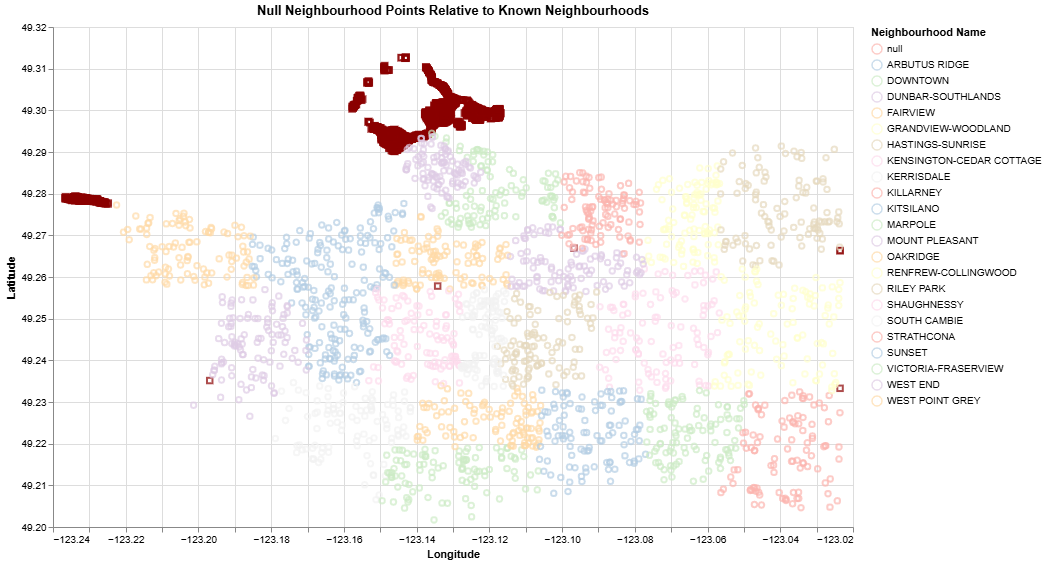

In [25]:
null_neighbourhood_relative_to_known_neighbourhood

In [26]:
# save as figure for report
null_neighbourhood_relative_to_known_neighbourhood.save("../../images/kli_eda1/null_neighbourhood_relative_to_known_neighbourhood.png")

#### Insight from the Figure:
- The null values (represented by wine-red squares) appear to cluster in specific areas, with some points located near known neighbourhoods. For example, TREE ID 208268 is near Dunbar-Southlands, suggesting these trees may have been overlooked during labelling.
- A large cluster of null points is located above the West End neighbourhood. This area is known as Stanley Park, which isn't actually considered a neighbourhood. Some consider it part of the West End, while others treat it as a separate area. This ambiguity may warrant treating it as its own neighbourhood in further analysis.
- Additionally, a significant number of unlabelled trees are located to the west of West Point Grey, an area known to be near the University of British Columbia (UBC). This could be considered a separate "University Neighbourhood" in future analyses to better capture the tree distribution in this region.